### Download fastText and facebook infersent models
Followed steps at: https://github.com/facebookresearch/InferSent

In [1]:
import nltk
nltk.download('punkt')
import sys
sys.path.append("../lib/InferSent")
from models import InferSent
import torch
import pandas as pd
import spacy
import numpy as np
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /home/ryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load('../models/encoder/infersent2.pkl'))
infersent.set_w2v_path("../models/fastText/crawl-300d-2M.vec")

In [3]:
squad_df = pd.read_csv("../corpora/squad-dev-v2.0.csv", index_col=0)
squad_df.head()

,contexts,questions,answer_texts,answer_starts
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94
2,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries,87
3,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256
4,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308


In [4]:
pd.set_option('max_colwidth', 100)
squad_df.sample(5)

,contexts,questions,answer_texts,answer_starts
4347,"In Ancient Greece, Diocles of Carystus (4th century BC) was one of several men studying the medi...",What is Pedanius Dioscorides known for?,writing a five volume book in his native Greek,220
9651,"In his extensively detailed report, Céloron wrote, ""All I can say is that the Natives of these l...",How were leaders back in Europe feeling about news from Celeron expedition?,each side proposing that action be taken,369
4017,The results of the Haensch study have since been confirmed and amended. Based on genetic evidenc...,What is the current status of the Haensch study?,confirmed and amended,49
5404,"Harvard is a large, highly residential research university. The nominal cost of attendance is hi...",How many individual libraries make up the main school library?,79 individual libraries,357
2208,"Oxygen storage methods include high pressure oxygen tanks, cryogenics and chemical compounds. Fo...",In what form is oxygen transported in smaller containers?,compressed gas;,691


In [5]:
nlp = spacy.load("en")

In [6]:
sentences = []

contexts = list(squad_df["contexts"].drop_duplicates())
for context in contexts:
    doc = nlp(context)
    sentences += [sentence.string.strip() for sentence in doc.sents]

In [7]:
infersent.build_vocab(sentences, tokenize=True)

Found 18481(/19809) words with w2v vectors
Vocab size : 18481


In [8]:
embeddings = infersent.encode(sentences, tokenize=True)

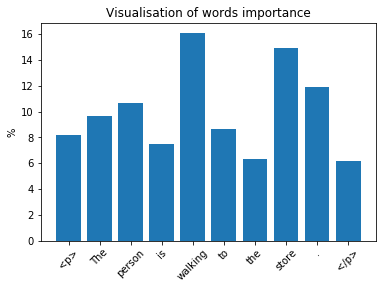

(tensor([[ 0.0075, -0.0281,  0.0683,  ..., -0.0171, -0.0331, -0.0084]],
        grad_fn=<MaxBackward0>),
 array([[0, 2, 4, ..., 7, 5, 1]]))

In [9]:
infersent.visualize('The person is walking to the store.', tokenize=True)

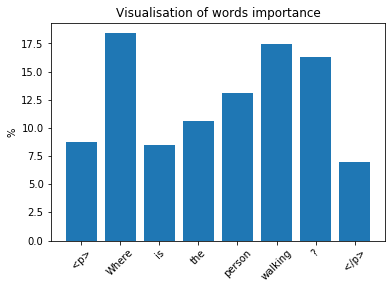

(tensor([[ 0.0075, -0.0292,  0.0551,  ..., -0.0055, -0.0356, -0.0193]],
        grad_fn=<MaxBackward0>),
 array([[0, 1, 5, ..., 3, 6, 1]]))

In [10]:
infersent.visualize('Where is the person walking?', tokenize=True)

In [11]:
def cosine_similarity(text1, text2):
    return np.dot(text1, text2)/(np.linalg.norm(text1) * np.linalg.norm(text2))

In [12]:
def split_sentences(paragraph):
    doc = nlp(paragraph)
    return [sentence.string.strip() for sentence in doc.sents]

In [13]:
def cosine_predict(statements, question):
    context_sentences = split_sentences(statements)
    most_similar, highest_sim = "", 0
    for sentence in context_sentences:
        similarity = cosine_similarity(infersent.encode([question])[0], infersent.encode([sentence])[0])
        if similarity > highest_sim:
            most_similar = sentence
            highest_sim = similarity
    return most_similar, highest_sim

In [ ]:
# sample_size = 100
sample_size = len(squad_df)
correct_answers = 0
for i, row in tqdm(squad_df.sample(n=sample_size).iterrows(), total=sample_size):
    most_similar, accuracy = cosine_predict(row["contexts"], row["questions"])    
    correct_answers += 1 if row["answer_texts"] in most_similar else 0
print(f"Cosine Similarity Accuracy: {correct_answers/sample_size}")

In [ ]:
# sample = squad_df.sample(n=1).iloc(0)[0]
sample = squad_df.iloc[7629]
sample.head()

In [ ]:
sample.contexts

In [ ]:
statements = split_sentences(sample["contexts"])
options = {"compact": True, "bg": "#323a48", "color": "white", "font": "Source Sans Pro"}
spacy.displacy.render(nlp(statements[0]), style="dep", options=options)

In [ ]:
statements

In [ ]:
cosine_predict(sample.contexts, sample.questions)

In [ ]:
statements = "The air was cold. The cat was orange. The cat walked across the grass. A bird flew in the sky."
question = "Where did the cat walk?"
cosine_predict(statements, question)

In [ ]:
infersent.visualize(question, tokenize=True)

In [ ]:
infersent.visualize("The cat walked across the grass.", tokenize=True)

In [ ]:
# TODO: Random Forest, Log Regression, RNN, AWD-LSTM, Make class for QA model to seed chatbot text gen